In [217]:
import pandas as pd
from math import log2
from sklearn.linear_model import Ridge
from sklearn import preprocessing as pr
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import resample, shuffle
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt

from lightgbm import LGBMRegressor as lr
import lightgbm as lgb

In [232]:
new_train_df = pd.read_csv("./data/train.csv")
new_test_df = pd.read_csv("./data/test.csv")

In [219]:
# boostrap data whose time is larger

train_df_large = new_train_df[new_train_df["time"]>20]
resampled_train_df = new_train_df[new_train_df["time"]<=20]

train_df_large = resample(train_df_large, n_samples=30)
# resampled_train_df = resample(resampled_train_df, n_samples=420)

In [220]:
# combine the resample large-time set and small-time set
new_train_df = train_df_large.append(resampled_train_df)
new_train_df.shape

(421, 15)

In [ ]:
# if resample result is good, save train set after resampling
pd.DataFrame.to_csv(new_train_df,"./new_train_1120_")

In [221]:
# save train set's mean and std
def mean_std(df):
    return [df.mean(axis=0),df.std(axis=0)]

# single column std
def stardardize(df):
    mean = df.mean(axis=0)
    df -= mean
    stda = df.std(axis=0)
    df /= stda
    
    return df

def std_for_test(df,col_name,c_dict):
    df -= c_dict[col_name][0]
    df /= c_dict[col_name][1]
    
    return df

def tran_l1_ratio(df):
    if df["penalty"] == "none":
        df["l1_ratio"] = -0.0001
    elif df["penalty"] == "l1":
        df["l1_ratio"] = 1
    elif df["penalty"] == "l2":
        df["l1_ratio"] = 0
        
    return df["l1_ratio"]

def l1(alpha,ratio,penalty):
    if penalty == 'l1':
        return(alpha)
    elif penalty == 'elasticnet':
        return(alpha * ratio)
    else:
        return(0)
    
def l2(alpha,ratio,penalty):
    if penalty == 'l2':
        return(alpha)
    elif penalty == 'elasticnet':
        return(alpha * (1-ratio))
    else:
        return(0)
    
def tran_n_jobs(df):
    if df == -1:
        df = 16
    
    df = (1 / df)
    return df

def tran_flipy(df):
    return 1 / df

def combine_sample_feature(df):
    sf = df["n_samples"] * df["n_features"]
    return sf

def combine_sample_feature_iter(df):
    sfm = df["n_samples"] * df["n_features"] * df["max_iter"]
    return sfm

In [164]:
new_train_df

,id,penalty,l1_ratio,alpha,max_iter,random_state,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,time
38,38,l1,0.884008,0.0001,944,502,2,1396,493,10,2,11,0.091745,61.538580,22.135640
233,233,elasticnet,0.217632,0.0001,260,580,1,1215,1380,8,3,11,0.072872,20.679437,24.661189
156,156,l1,0.298078,0.0010,952,819,1,717,814,6,3,8,0.083516,15.582684,18.201372
336,336,l1,0.255320,0.0100,942,676,2,1325,1302,8,3,11,0.072365,59.063374,38.472806
173,173,elasticnet,0.283452,0.0100,911,612,2,760,724,10,3,11,0.033391,53.705492,16.926400
381,381,l1,0.326555,0.0010,997,399,1,878,1343,3,3,7,0.064169,2.414756,19.295623
350,350,l1,0.112475,0.0100,947,356,2,868,544,10,2,10,0.065059,99.432926,14.723936
48,48,elasticnet,0.541497,0.0010,757,717,1,910,1059,5,2,10,0.028575,99.664473,25.186214
38,38,l1,0.884008,0.0001,944,502,2,1396,493,10,2,11,0.091745,61.538580,22.135640
173,173,elasticnet,0.283452,0.0100,911,612,2,760,724,10,3,11,0.033391,53.705492,16.926400


In [222]:
# new_train_df["s_multi_f"]= new_train_df[["n_samples","n_features","max_iter"]].apply(combine_sample_feature_iter, axis=1)
new_train_df["s_multi_f"]= new_train_df[["n_samples","n_features"]].apply(combine_sample_feature, axis=1)
new_train_df["n_jobs"] = new_train_df["n_jobs"].apply(tran_n_jobs)
# new_train_df['l1'] = new_train_df.apply(lambda row: l1(row['alpha'],row['l1_ratio'],row['penalty']),axis = 1)
# new_train_df['l2'] = new_train_df.apply(lambda row: l2(row['alpha'],row['l1_ratio'],row['penalty']),axis = 1)
new_train_df["l1_ratio_new"]= new_train_df[["penalty","l1_ratio"]].apply(tran_l1_ratio,axis=1)
new_train_df["flip_y"]= new_train_df["flip_y"].apply(tran_flipy)

In [223]:
# what columns should be removed
del_ones = ["penalty","l1_ratio","random_state","id","alpha","n_samples","n_features"]

for col in del_ones:
    new_train_df = new_train_df.drop([col],axis=1)

In [224]:
cols_to_std = ['n_classes','n_clusters_per_class', 'n_informative', 'flip_y', 'scale',"s_multi_f","max_iter","l1","l2"]

col_mean_std_dict = {}
for col in cols_to_std:
    col_mean_std_dict[col] = mean_std(new_train_df[col])
    
col_mean_std_dict

{'n_classes': [5.869358669833729, 2.4697285019674946],
 'n_clusters_per_class': [3.4299287410926365, 1.0988986887986587],
 'n_informative': [8.67458432304038, 1.5247310865608652],
 'flip_y': [115.23859079238474, 1053.7493736857825],
 'scale': [50.190125108966704, 29.606051254503154],
 's_multi_f': [602427.0997624703, 426166.71796670585],
 'max_iter': [565.4418052256532, 266.33929231173227],
 'l1': [0.0012953642886669617, 0.002909688405895021],
 'l2': [0.0013196000818793568, 0.0029383668753448075]}

In [225]:
# log time to smooth
new_train_df["time"] = new_train_df["time"].apply(np.log)

In [226]:
new_train_df[cols_to_std] = new_train_df[cols_to_std].apply(stardardize)

In [227]:
lrmodel = lr(learning_rate=0.1,n_estimators=200,random_state=123)

lrmodel.fit(new_train_df.drop("time",axis=1),new_train_df["time"])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
       random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

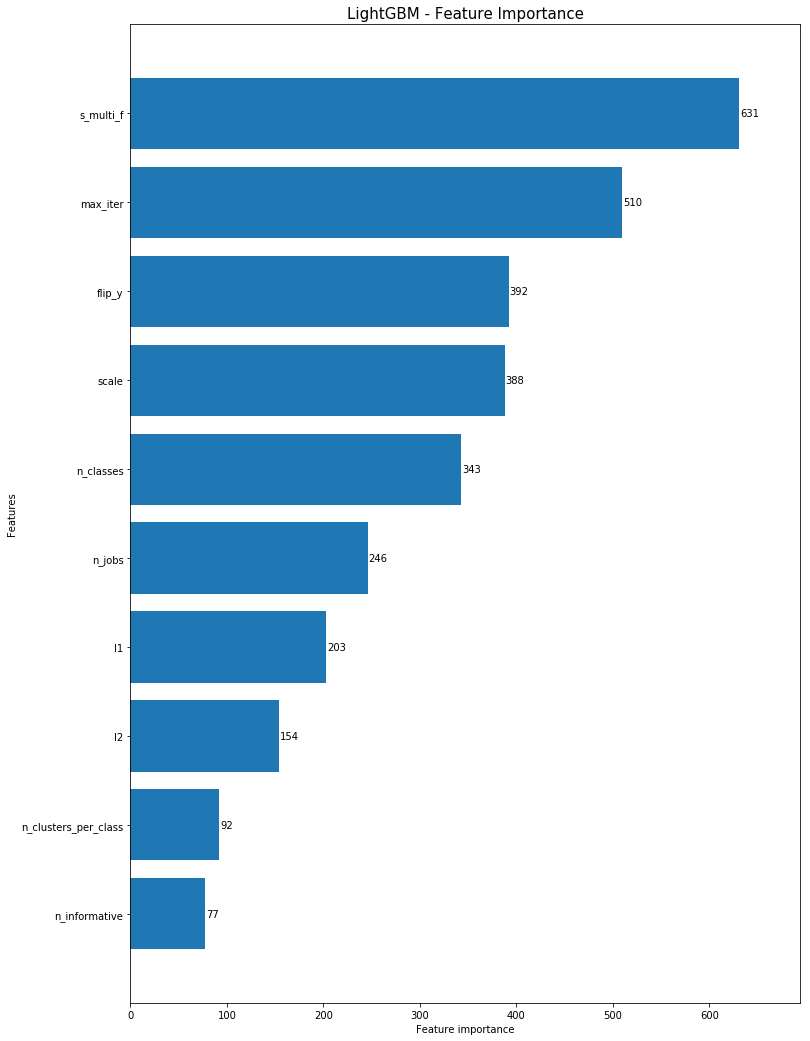

In [236]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lrmodel, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [228]:
cross_val_score(lrmodel,new_train_df.drop("time",axis=1),new_train_df["time"],cv=5).mean()

0.9229970352957663

In [233]:
# transfer for test set features

new_test_df["l1_ratio_new"]= new_test_df[["penalty","l1_ratio"]].apply(tran_l1_ratio, axis=1)
# new_test_df["n_jobs"] = new_test_df["n_jobs"].apply(tran_n_jobs)
new_test_df["s_multi_f"]= new_test_df[["n_samples","n_features"]].apply(combine_sample_feature, axis=1)
new_test_df["flip_y"]= new_test_df["flip_y"].apply(tran_flipy)
# new_test_df['l1'] = new_test_df.apply(lambda row: l1(row['alpha'],row['l1_ratio'],row['penalty']),axis = 1)
# new_test_df['l2'] = new_test_df.apply(lambda row: l2(row['alpha'],row['l1_ratio'],row['penalty']),axis = 1)

for col in del_ones:
    new_test_df = new_test_df.drop(col,axis=1)

In [234]:
for col in cols_to_std:
    new_test_df[col] = std_for_test(new_test_df[col],col,col_mean_std_dict)

In [235]:
lr_result = lrmodel.predict(new_test_df)
# result = replace_minus(lr_result)

exp_result = np.exp(lr_result)
print(exp_result)

[ 1.91932882 23.15979646  2.33358594  1.68996426  2.97071758 24.80240749
  3.81426298  2.54457098 13.48331944  0.30971199  5.26217822  8.47435447
  0.8341291  47.75211585  0.2777608   2.28189898  1.79792868  9.28686638
 11.56964831  1.75154758  0.68597551  0.48806503  0.8318025   0.54915987
  3.76446055  1.90456673  2.53868676 13.39340869  2.03498471  3.90130874
 17.7366926   3.78481975  2.31211622  6.38621859 20.42760255  2.78110645
 13.95299613  2.56533662  2.55649883  1.8476723  18.94484599 18.58774843
  0.64553475  9.28166524  2.43270656  5.1746926  12.30591126  1.35778736
  7.34636932  2.94650343  0.43795386 59.53856878  0.38835816 10.1213525
  4.10184541  0.86122668  5.04552203  3.09308732  1.23877332  0.68639459
  1.47004704 21.82151288  0.62227042  3.99333076 10.37702294 20.19089929
  1.38150265  1.64905564 16.77384602  0.57519456  0.8412892   1.29949985
 13.33846542  0.27295927 10.37974637  3.13453759  1.2117939   5.79541417
 13.73891421  1.20782653  4.54418647  5.47669847  6.

In [116]:
result_df = pd.DataFrame(columns=["time"])
result_df["time"] = exp_result
result_df.index.name = "Id"

result_df.to_csv("./data/submission1123_10.csv")